### Kaggle Link
https://www.kaggle.com/uciml/sms-spam-collection-dataset

### Context

The SMS Spam Collection is a set of SMS tagged messages that have been collected for SMS Spam research. It contains one set of SMS messages in English of 5,574 messages, tagged acording being ham (legitimate) or spam.

### Content

The files contain one message per line. Each line is composed by two columns: v1 contains the label (ham or spam) and v2 contains the raw text.

### Resources

https://www.coursera.org/learn/python-text-mining/

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

%matplotlib inline

spam_data = pd.read_csv('../Data/Kaggle/spam.csv', encoding='latin-1')
spam_data.head()

,v1,v2,Unnamed: 2,Unnamed: 3,Unnamed: 4
0,ham,"Go until jurong point, crazy.. Available only ...",NaN,NaN,NaN
1,ham,Ok lar... Joking wif u oni...,NaN,NaN,NaN
2,spam,Free entry in 2 a wkly comp to win FA Cup fina...,NaN,NaN,NaN
3,ham,U dun say so early hor... U c already then say...,NaN,NaN,NaN
4,ham,"Nah I don't think he goes to usf, he lives aro...",NaN,NaN,NaN


In [2]:
spam_data = spam_data.drop(['Unnamed: 2','Unnamed: 3','Unnamed: 4'], axis=1)
spam_data = spam_data.rename(columns = {'v1': 'target','v2': 'text'})

spam_data.head()

,target,text
0,ham,"Go until jurong point, crazy.. Available only ..."
1,ham,Ok lar... Joking wif u oni...
2,spam,Free entry in 2 a wkly comp to win FA Cup fina...
3,ham,U dun say so early hor... U c already then say...
4,ham,"Nah I don't think he goes to usf, he lives aro..."


### Pre-processing

Before training any model, let's do more data pre-processing. Specifically, I'm goint to:

* Remove stop words
* Put all phrases in lower case
* Stem words

In [3]:
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize 
from nltk.stem import SnowballStemmer

In [4]:
stop_words = set(stopwords.words('english'))
stemmer = SnowballStemmer('english')

In [5]:
spam_data['parsed'] = spam_data['text'].apply(lambda x: x.lower())
spam_data['parsed'] = spam_data['text'].apply(lambda x: word_tokenize(x))
spam_data['parsed'] = spam_data['text'].apply(lambda x: [word for word in str(x).split() if word not in stop_words])
spam_data['parsed'] = spam_data['parsed'].apply(lambda x: [stemmer.stem(word) for word in x])
spam_data['parsed'] = spam_data['parsed'].apply(lambda x: ' '.join(x))

In [6]:
spam_data.head()

,target,text,parsed
0,ham,"Go until jurong point, crazy.. Available only ...","go jurong point, crazy.. avail bugi n great wo..."
1,ham,Ok lar... Joking wif u oni...,ok lar... joke wif u oni...
2,spam,Free entry in 2 a wkly comp to win FA Cup fina...,free entri 2 wkli comp win fa cup final tkts 2...
3,ham,U dun say so early hor... U c already then say...,u dun say earli hor... u c alreadi say...
4,ham,"Nah I don't think he goes to usf, he lives aro...","nah i don't think goe usf, live around though"


### Data Exploration

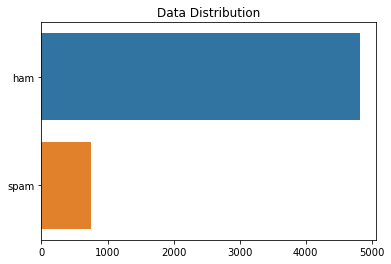

In [7]:
s = spam_data['target'].value_counts()
sns.barplot(x=s.values, y=s.index)
plt.title('Data Distribution')

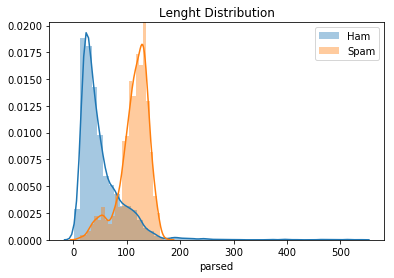

In [8]:
s1 = spam_data[spam_data['target'] == 'ham']['parsed'].str.len()
sns.distplot(s1, label='Ham')
s2 = spam_data[spam_data['target'] == 'spam']['parsed'].str.len()
sns.distplot(s2, label='Spam')
plt.title('Lenght Distribution')
plt.legend()

In [9]:
print(s1.mean(), s2.mean())

51.72683937823834 113.88085676037483


We can notice that spams messages are often longer than ham messages.

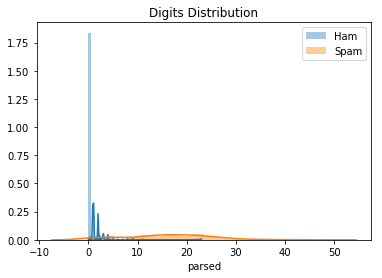

In [10]:
s1 = spam_data[spam_data['target'] == 'ham']['parsed'].str.replace(r'\D+', '').str.len()
sns.distplot(s1, label='Ham')
s2 = spam_data[spam_data['target'] == 'spam']['parsed'].str.replace(r'\D+', '').str.len()
sns.distplot(s2, label='Spam')
plt.title('Digits Distribution')
plt.legend()

In [11]:
print(s1.mean(), s2.mean())

0.2992746113989637 15.759036144578314


From this plot, it's clear that the digits distribution in ham messages are rigth skewed, presenting lower mean of digits than spam messages.

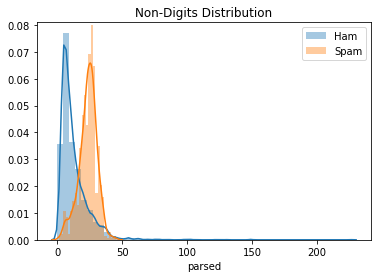

In [12]:
s1 = spam_data[spam_data['target'] == 'ham']['parsed'].str.replace(r'\w+', '').str.len()
sns.distplot(s1, label='Ham')
s2 = spam_data[spam_data['target'] == 'spam']['parsed'].str.replace(r'\w+', '').str.len()
sns.distplot(s2, label='Spam')
plt.title('Non-Digits Distribution')
plt.legend()

In [13]:
print(s1.mean(), s2.mean())

12.688082901554404 23.555555555555557


These distributions resembles the ones regarding the text messages. Here, the values are smaller, though. Hams presents less non-digits than spams.

In [14]:
spam_data.groupby('target').describe()

parsed                                                                 \
        count unique                                                top freq   
target                                                                         
ham      4825   4513                             sorry, i'll call later   30   
spam      747    641  pleas call custom servic repres freephon 0808 ...    4   

        text                                                                 
       count unique                                                top freq  
target                                                                       
ham     4825   4516                             Sorry, I'll call later   30  
spam     747    653  Please call our customer service representativ...    4

### Count Vectorizer vs. Tfidf

In [15]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(spam_data['parsed'], 
                                                    spam_data['target'], 
                                                    random_state=0)

- ** Count Vectorizer **

In [16]:
from sklearn.feature_extraction.text import CountVectorizer

vect = CountVectorizer().fit(X_train)
print('Vocabulary len:', len(vect.get_feature_names()))
print('Longest word:', max(vect.vocabulary_, key=len))

X_train_vectorized = vect.transform(X_train)

Vocabulary len: 6910
Longest word: com1win150ppmx3age16subscript


In [17]:
from sklearn.naive_bayes import MultinomialNB

model = MultinomialNB(alpha=0.1)
model.fit(X_train_vectorized, y_train)

MultinomialNB(alpha=0.1, class_prior=None, fit_prior=True)

In [18]:
# get the feature names as numpy array
feature_names = np.array(vect.get_feature_names())

# Sort the coefficients from the model
sorted_coef_index = model.coef_[0].argsort()

# Find the 10 smallest and 10 largest coefficients
# The 10 largest coefficients are being indexed using [:-11:-1] 
# so the list returned is in order of largest to smallest
print('Smallest Coefs:\n{}\n'.format(feature_names[sorted_coef_index[:10]]))
print('Largest Coefs: \n{}'.format(feature_names[sorted_coef_index[:-11:-1]]))

Smallest Coefs:
['ûówel' 'hurt' 'hurrican' 'shivratri' 'hunt' 'hunny' 'hunni' 'hurts'
 'shld' 'hungri']

Largest Coefs: 
['call' 'free' 'txt' 'ur' 'text' 'stop' 'now' 'you' 'mobil' 'claim']


In [19]:
from sklearn.metrics import accuracy_score

y_pred = model.predict(vect.transform(X_test))
print('Accuracy: %.2f%%' % (accuracy_score(y_test, y_pred) * 100))

Accuracy: 98.71%


- **Tfidf**

 Let's ignore terms that have a document frequency strictly lower than 3.

In [20]:
from sklearn.feature_extraction.text import TfidfVectorizer

vect = TfidfVectorizer(min_df=3).fit(X_train)
print('Vocabulary len:', len(vect.get_feature_names()))
print('Longest word:', max(vect.vocabulary_, key=len))

X_train_vectorized = vect.transform(X_train)

Vocabulary len: 2166
Longest word: tscs087147403231winawk


In [21]:
model = MultinomialNB(alpha=0.1)
model.fit(X_train_vectorized, y_train)

MultinomialNB(alpha=0.1, class_prior=None, fit_prior=True)

In [22]:
feature_names = np.array(vect.get_feature_names())

sorted_coef_index = model.coef_[0].argsort()

print('Smallest Coefs:\n{}\n'.format(feature_names[sorted_coef_index[:10]]))
print('Largest Coefs: \n{}'.format(feature_names[sorted_coef_index[:-11:-1]]))

Smallest Coefs:
['lar' 'manag' 'major' 'maintain' 'mail' 'maid' 'mah' 'magic' 'mad' 'macho']

Largest Coefs: 
['call' 'free' 'txt' 'text' 'stop' 'claim' 'mobil' 'ur' 'repli' 'now']


In [23]:
from sklearn.metrics import accuracy_score

y_pred = model.predict(vect.transform(X_test))
print('Accuracy: %.2f%%' % (accuracy_score(y_test, y_pred) * 100))

Accuracy: 98.42%


### Feature Engineering

In the follwing, let's do some feature engineering to try to improve the performance of our model.

In [24]:
def add_feature(X, feature_to_add):
    """
    Returns sparse feature matrix with added feature.
    feature_to_add can also be a list of features.
    """
    from scipy.sparse import csr_matrix, hstack
    return hstack([X, csr_matrix(feature_to_add).T], 'csr')

---

#### First Model

First, let's ignore terms that have a document frequency strictly lower than 3.
Using this document-term matrix and an additional feature, the length of document (number of characters), we will test how our Tfidf performs.

In [25]:
vect = TfidfVectorizer(min_df=5).fit(X_train)
print('Vocabulary len:', len(vect.get_feature_names()))
print('Longest word:', max(vect.vocabulary_, key=len))

X_train_vectorized = vect.transform(X_train)

X_train_vectorized = add_feature(X_train_vectorized, X_train.str.len())

Vocabulary len: 1409
Longest word: complimentari


In [26]:
model = MultinomialNB(alpha=0.1)
model.fit(X_train_vectorized, y_train)

MultinomialNB(alpha=0.1, class_prior=None, fit_prior=True)

In [27]:
index = np.array(vect.get_feature_names() + ['length_of_doc'])
values  = model.coef_[0]
features_series = pd.Series(data=values,index=index)

print('Smallest Coefs:\n{}\n'.format(features_series.nsmallest(10).index.values.tolist()))
print('Largest Coefs: \n{}'.format(features_series.nlargest(10).index.values.tolist()))

Smallest Coefs:
['8th', 'aathi', 'abiola', 'abl', 'about', 'abt', 'accept', 'across', 'actual', 'add']

Largest Coefs: 
['length_of_doc', 'call', 'free', 'txt', 'text', 'stop', 'claim', 'mobil', 'ur', 'repli']


In [28]:
X_test_vectorized = vect.transform(X_test)
X_test_vectorized = add_feature(X_test_vectorized, X_test.str.len())
    
y_pred = model.predict(X_test_vectorized)
print('Accuracy: %.2f%%' % (accuracy_score(y_test, y_pred) * 100))

Accuracy: 98.42%


---

#### Second Model

Now let's use a Tfidf ignoring terms that have a document frequency strictly lower than **5** and using **word n-grams from n=1 to n=3** (unigrams, bigrams and trigrams).

We will also make use of the following additional features:
* the length of document (number of characters)
* number of digits per document

In [29]:
vect = TfidfVectorizer(min_df=5, ngram_range=(1, 3)).fit(X_train)
print('Vocabulary len:', len(vect.get_feature_names()))
print('Longest word:', max(vect.vocabulary_, key=len))

X_train_vectorized = vect.transform(X_train)

X_train_vectorized = add_feature(X_train_vectorized, X_train.str.len())
X_train_vectorized = add_feature(X_train_vectorized, X_train.str.replace(r'\D+', '').str.len())

Vocabulary len: 2231
Longest word: mobileupd8 08000839402 call2optout


In [30]:
model = MultinomialNB(alpha=0.1)
model.fit(X_train_vectorized, y_train)

MultinomialNB(alpha=0.1, class_prior=None, fit_prior=True)

In [31]:
index = np.array(vect.get_feature_names() + ['length_of_doc', 'digit_count'])
values  = model.coef_[0]
features_series = pd.Series(data=values,index=index)

print('Smallest Coefs:\n{}\n'.format(features_series.nsmallest(10).index.values.tolist()))
print('Largest Coefs: \n{}'.format(features_series.nlargest(10).index.values.tolist()))

Smallest Coefs:
['8th', 'aathi', 'abiola', 'abl', 'about', 'abt', 'accept', 'across', 'across sea', 'actual']

Largest Coefs: 
['length_of_doc', 'digit_count', 'call', 'free', 'txt', 'text', 'stop', 'repli', 'now', 'claim']


In [32]:
X_test_vectorized = vect.transform(X_test)
X_test_vectorized = add_feature(X_test_vectorized, X_test.str.len())
X_test_vectorized = add_feature(X_test_vectorized, X_test.str.replace(r'\D+', '').str.len())
    
y_pred = model.predict(X_test_vectorized)
print('Accuracy: %.2f%%' % (accuracy_score(y_test, y_pred) * 100))

Accuracy: 97.34%


--- 

#### Third Model

Finally, let's use a Count Vectorizer ignoring terms that have a document frequency strictly lower than **5** and using **character n-grams from n=2 to n=5.**

To tell Count Vectorizer to use character n-grams we pass in `analyzer='char_wb'` which creates character n-grams only from text inside word boundaries. This should make the model more robust to spelling mistakes.

At this time we are goint to use these additional features:
* the length of document (number of characters)
* number of digits per document
* number of non-word characters (anything other than a letter, digit or underscore.)

In [33]:
vect = CountVectorizer(min_df=5, ngram_range=(2, 5), analyzer='char_wb').fit(X_train)
print('Vocabulary len:', len(vect.get_feature_names()))
print('Longest word:', max(vect.vocabulary_, key=len))

X_train_vectorized = vect.transform(X_train)

X_train_vectorized = add_feature(X_train_vectorized, X_train.str.len())
X_train_vectorized = add_feature(X_train_vectorized, X_train.str.replace(r'\D+', '').str.len())
X_train_vectorized = add_feature(X_train_vectorized, X_train.str.replace(r'\w+', '').str.len())

Vocabulary len: 15003
Longest word:  i'll


In [34]:
model = MultinomialNB(alpha=0.1)
model.fit(X_train_vectorized, y_train)

MultinomialNB(alpha=0.1, class_prior=None, fit_prior=True)

In [35]:
index = np.array(vect.get_feature_names() + ['length_of_doc', 'digit_count', 'non_word_char_count'])
values = model.coef_[0]
features_series = pd.Series(data=values,index=index)

print('Smallest Coefs:\n{}\n'.format(features_series.nsmallest(10).index.values.tolist()))
print('Largest Coefs: \n{}'.format(features_series.nlargest(10).index.values.tolist()))

Smallest Coefs:
[' !! ', " !!'", " !!''", ' $ ', ' &a', ' &am', ' &amp', ' &l', ' &lt', ' &lt;']

Largest Coefs: 
['length_of_doc', 'non_word_char_count', 'digit_count', 't ', ' c', '. ', ' t', ' s', 'e ', 're']


In [36]:
X_test_vectorized = vect.transform(X_test)
X_test_vectorized = add_feature(X_test_vectorized, X_test.str.len())
X_test_vectorized = add_feature(X_test_vectorized, X_test.str.replace(r'\D+', '').str.len())
X_test_vectorized = add_feature(X_test_vectorized, X_test.str.replace(r'\w+', '').str.len())
    
y_pred = model.predict(X_test_vectorized)
print('Accuracy: %.2f%%' % (accuracy_score(y_test, y_pred) * 100))

Accuracy: 99.07%
